# National Newspaper Data Collection and Cleaning

Purpose of this notebook is to gather and clean the national newspaper data. We start out with the publicly accessible data set "All the News 2.0". The data set is created by Andrew Thompson and available to download from [Components (download via ProtonDrive)](https://components.one/datasets/all-the-news-2-news-articles-dataset).

## Gathering and Preprocessing National Newspaper Datasets

Outline: 
- Download data set
- Filter for relevant newspaper (publication column). Here: "The New York Times".
- Explore the filtered data
- Save the new data set in the GitHub repo or as a gist, or a sample of the data, depending on its size. 

In [25]:
# Read in and filter the data

# name (=path): all-the-news-2-1.csv
# appraoch: use DuckDB + SQL push-down to filter the data for outlets (publication column) of our choice. This way we never load the entire dataset into memory.

import duckdb

csv_path    = "all-the-news-2-1.csv"

# DuckDB will only scan rows matching your WHERE clause
df_nyt = duckdb.query(f"""
    SELECT *
      FROM read_csv_auto('{csv_path}')
     WHERE publication='The New York Times'
""").to_df()

df_nyt.head()



,date,year,month,day,author,title,article,url,section,publication
0,2019-01-14 13:38:12,2019,1.0,14,None,Sailors Unite Against Harbinger Capital-Backed...,None,http://dealbook.nytimes.com/2011/07/13/boaters...,boaters-concerned-over-falcones-lightsquared,The New York Times
1,2019-01-14 13:14:59,2019,1.0,14,None,How Much Did Warren Buffett Pay For BofA Anywa...,None,http://dealbook.nytimes.com/2011/08/25/how-big...,how-big-was-buffetts-discount,The New York Times
2,2019-08-21 15:45:00,2019,8.0,21,None,SEC.gov | HOME,EDGAR \nCompany Filings - Free access to 21 mi...,http://dealbook.nytimes.com/2011/08/23/in-wake...,in-wake-of-quake-s-e-c-suspends-edgar-system,The New York Times
3,2019-08-05 13:20:28,2019,8.0,5,None,Reviews - The Verge,None,http://dealbook.nytimes.com/2011/08/31/t-mobil...,t-mobile-chief-admits-he-was-surprised-by-just...,The New York Times
4,2019-08-23 10:00:46,2019,8.0,23,None,Home - Motor Expo,None,http://wheels.blogs.nytimes.com/2011/09/16/new...,new-york-motorexpo-returns-to-lower-manhattan-...,The New York Times


In [26]:
# Compute df_nyt size in MB
memory_bytes = df_nyt.memory_usage(deep=True).sum()
memory_mb    = memory_bytes / (1024 ** 2)
print(f"df_nyt size: {memory_mb:.2f} MB")

df_nyt size: 2734.58 MB


In [27]:
# Random sample of 10'000 rows
df_nyt_sample = df_nyt.sample(n=10000, random_state=42)

# new column url_short which is the url but only the domain and potential subdomain, as well as the top-level domain.
# e.g. https://www.nytimes.com/2023/10/01/us/politics/trump-2024.html
# becomes www.nytimes.com
df_nyt_sample['url_short'] = df_nyt_sample['url'].str.extract(r'^(?:https?://)?(?:www\.)?([^/]+)')[0]

# Check the new column
df_nyt_sample['url_short'].head()
# Check the number of unique values
df_nyt_sample['url_short'].nunique()
# Check the number of unique values
df_nyt_sample['url_short'].value_counts()

url_short
nytimes.com                            9818
cn.nytimes.com                           39
lens.blogs.nytimes.com                   23
cn.nytstyle.com                          18
well.blogs.nytimes.com                   16
learning.blogs.nytimes.com               15
artsbeat.blogs.nytimes.com               14
iht-retrospective.blogs.nytimes.com      12
wordplay.blogs.nytimes.com               10
takingnote.blogs.nytimes.com              7
krugman.blogs.nytimes.com                 7
bits.blogs.nytimes.com                    6
news.blogs.nytimes.com                    6
dotearth.blogs.nytimes.com                5
kristof.blogs.nytimes.com                 2
douthat.blogs.nytimes.com                 1
parenting.blogs.nytimes.com               1
Name: count, dtype: int64

In [28]:
# Average number of words in the title
df_nyt_sample['title'].str.split().str.len().mean()

np.float64(9.07204322593556)

In [29]:
# Average number of words in the article
df_nyt_sample['article'].str.split().str.len().mean()

np.float64(920.7693321171582)

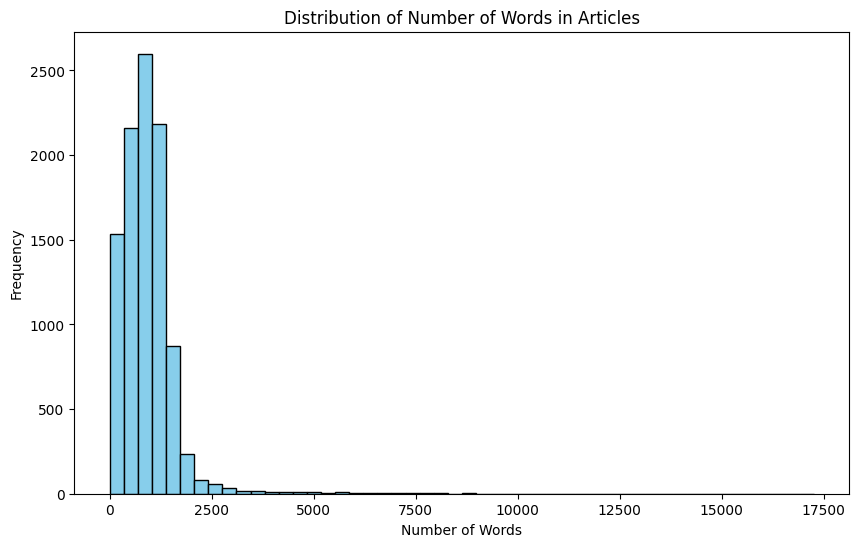

In [30]:
# Distribution of the number of words in the article
import matplotlib.pyplot as plt

word_counts = df_nyt_sample['article'].dropna().str.split().str.len()
plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Words in Articles')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

C:\Users\MarxerB\AppData\Local\Temp\ipykernel_11220\874327245.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M') \


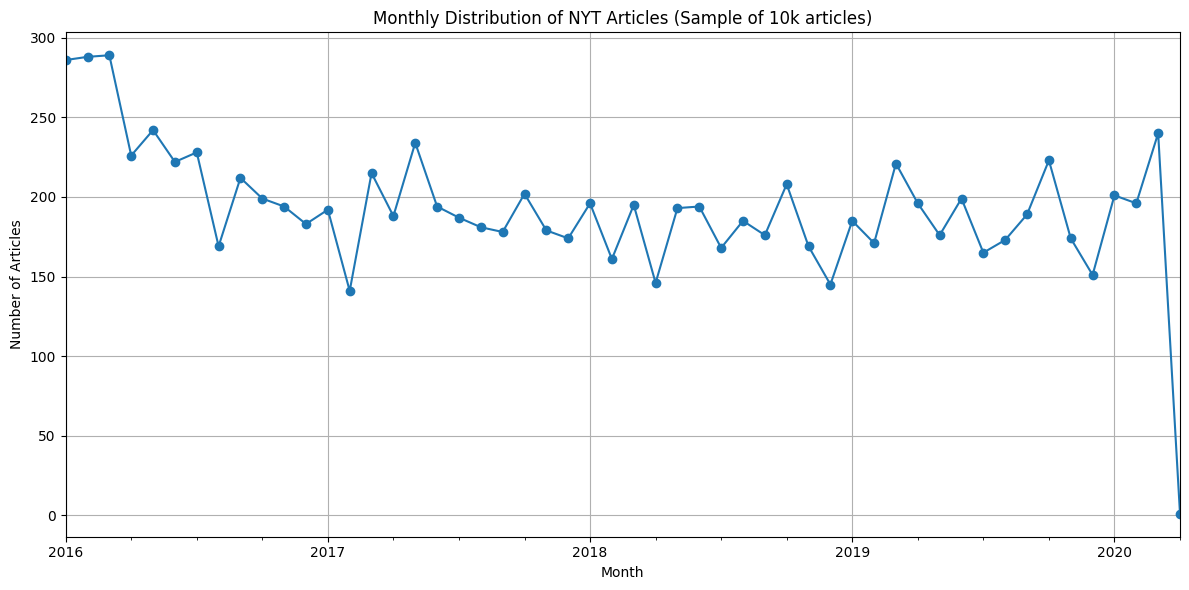

In [ ]:
# Distribution of articles over time (sample)
import pandas as pd
import matplotlib.pyplot as plt

# ensure 'date' is datetime
df_nyt_sample['date'] = pd.to_datetime(df_nyt_sample['date'], errors='coerce')

# count articles per month
monthly_counts = df_nyt_sample.set_index('date') \
    .resample('M') \
    .size()

# plot
plt.figure(figsize=(12, 6))
monthly_counts.plot(marker='o', linestyle='-')
plt.title("Monthly Distribution of NYT Articles (Sample of 10k articles)")
plt.xlabel("Month")
plt.ylabel("Number of Articles")
plt.grid(True)
plt.tight_layout()
plt.show()


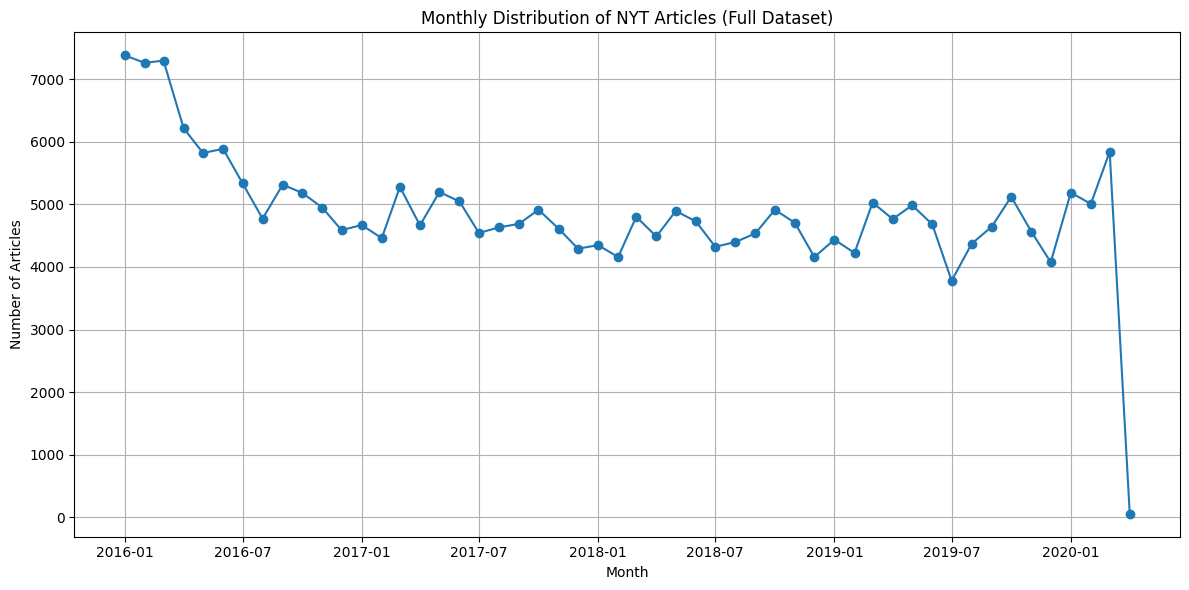

In [ ]:
# --- Aggregate full df_nyt by month via DuckDB and plot ---

import duckdb
import matplotlib.pyplot as plt

# 1) run SQL aggregation on the full NYT dataset
df_monthly = duckdb.query(f"""
    SELECT
      date_trunc('month', CAST(date AS DATE)) AS month,
      COUNT(*) AS n_articles
    FROM read_csv_auto('{csv_path}')
    WHERE publication = 'The New York Times'
    GROUP BY 1
    ORDER BY 1
""").to_df()

# 2) plot the full‐data monthly counts
plt.figure(figsize=(12, 6))
plt.plot(df_monthly['month'], df_monthly['n_articles'], marker='o', linestyle='-')
plt.title("Monthly Distribution of NYT Articles (Full Dataset)")
plt.xlabel("Month")
plt.ylabel("Number of Articles")
plt.grid(True)
plt.tight_layout()
plt.show()

Top terms per topic:
Topic 1: new, like, book, music, time, work, life, film, world, story
Topic 2: like, people, said, just, time, don, know, new, make, day
Topic 3: trump, said, president, house, news, white, investigation, did, times, new
Topic 4: said, united, china, american, states, war, military, government, president, state
Topic 5: game, team, said, season, que, players, games, los, year, league
Topic 6: said, government, court, people, country, states, united, law, state, rights
Topic 7: trump, said, president, republican, party, campaign, democratic, people, democrats, state
Topic 8: said, police, school, new, city, york, university, year, people, father
Topic 9: said, company, percent, new, year, companies, million, billion, money, business
Topic 10: said, new, city, york, art, like, street, year, museum, home


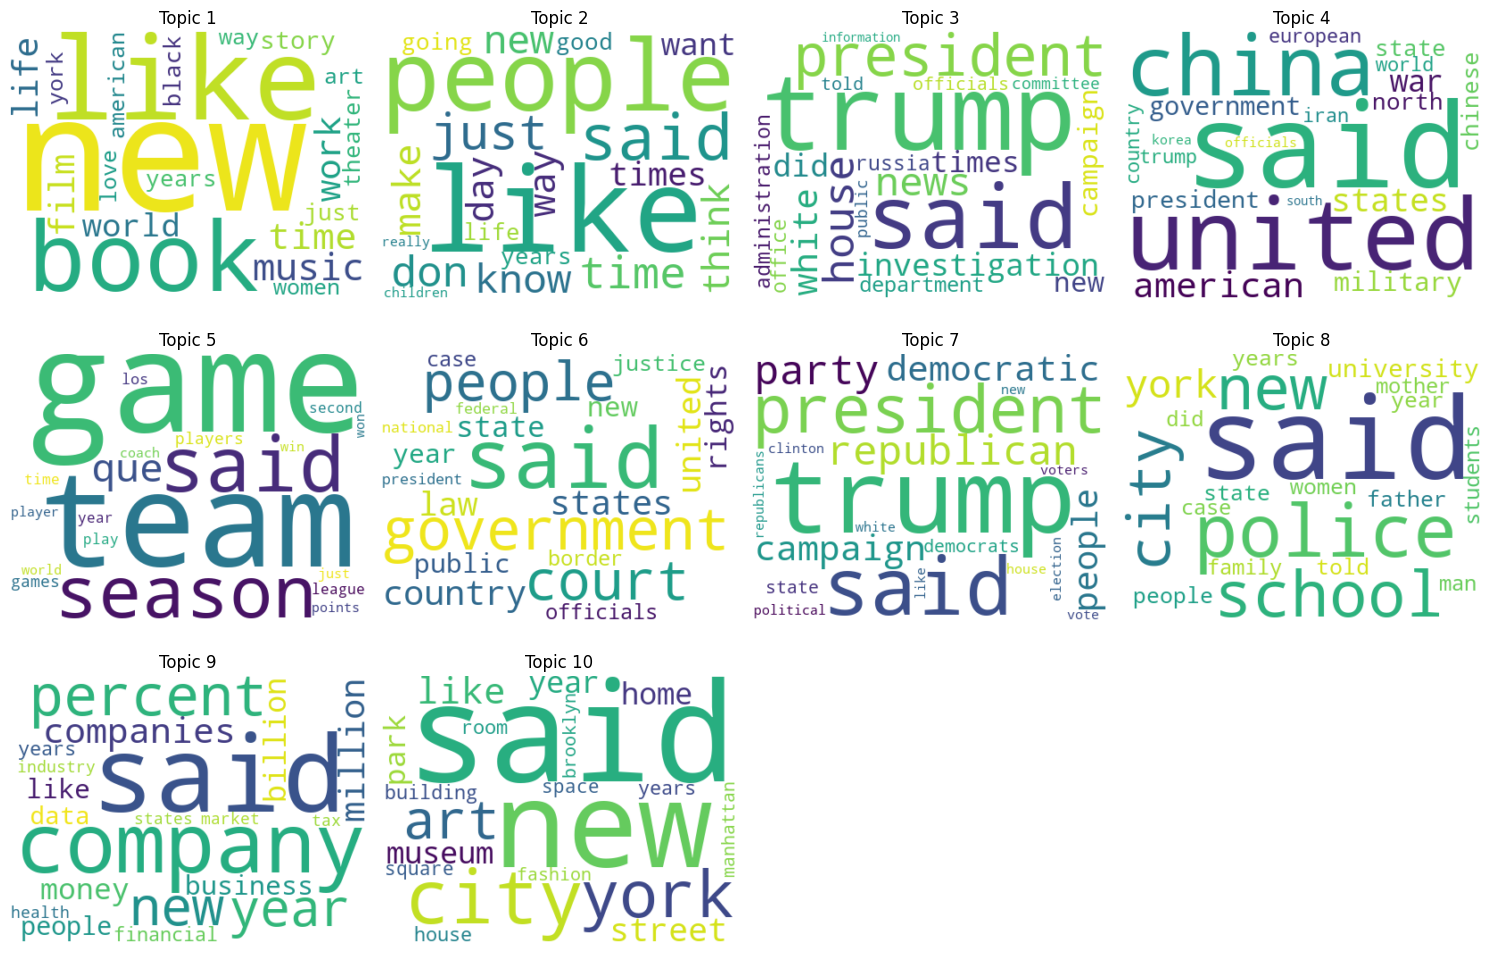

In [34]:
# --- Topic Modeling + WordCloud Visualization (no NLTK) ---

# 1) imports
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 2) prepare corpus
texts = df_nyt_sample['article'].fillna('').tolist()

# 3) vectorize using built-in English stop words
vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=10,
    stop_words='english',
    token_pattern=r'\b[a-zA-Z]{3,}\b'
)
dtm = vectorizer.fit_transform(texts)

# 4) fit LDA
n_topics = 10
lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=20,
    learning_method='batch',
    random_state=42
)
lda.fit(dtm)

# 5) display top terms per topic
feature_names = vectorizer.get_feature_names_out()
def display_topics(model, feature_names, top_n=10):
    for i, comp in enumerate(model.components_):
        terms = [feature_names[j] for j in comp.argsort()[-top_n:][::-1]]
        print(f"Topic {i+1}: {', '.join(terms)}")
print("Top terms per topic:")
display_topics(lda, feature_names, top_n=10)

# 6) word-cloud visualization per topic
plt.figure(figsize=(15, 10))
for i, comp in enumerate(lda.components_):
    idx   = comp.argsort()[-20:]
    freqs = {feature_names[j]: comp[j] for j in idx}
    wc    = WordCloud(width=400, height=300,
                      background_color='white',
                      stopwords=STOPWORDS)\
               .generate_from_frequencies(freqs)
    plt.subplot(3, 4, i+1)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {i+1}")
plt.tight_layout()
plt.show()

Note: you may need to restart the kernel to use updated packages.
Topic 1: 396, 961, alle, alpage, ageyness, 248, allegations, 243, agganis, amazonas
Topic 2: algoritmo, 1889, 1891, agence, 289, 434, ansaldo, alisson, alguien, apptopia
Topic 3: 4226, aggie, 14, aggies, 300s, 30th, akatade, 122, aecom, 124th
Topic 4: 13d, affectionately, anria, affected, africobra, 1411, 141st, aquatics, afroditi, 459
Topic 5: alzheimer, antje, africobra, airliner, additional, alboroto, apurva, antennae, acordo, aqil
Topic 6: aerated, adityanath, aeolian, ajristan, 1746, alisson, amthor, actualizan, 278, 1906
Topic 7: abolishes, aircraft, 3ld, apologize, adriaen, 2010s, 5857, absinthe, 645, 6010
Topic 8: alhadeff, accusers, amazonbasics, abdicate, abdy, 1938, advertencias, anzeiger, actionable, aceptación
Topic 9: 2030s, accomplishable, abolishes, apostaron, apps, 300s, adriana, abolishing, aby, 2031
Topic 10: acela, aceite, aced, accustom, accustomed, ann, andie, activa, 906, 151


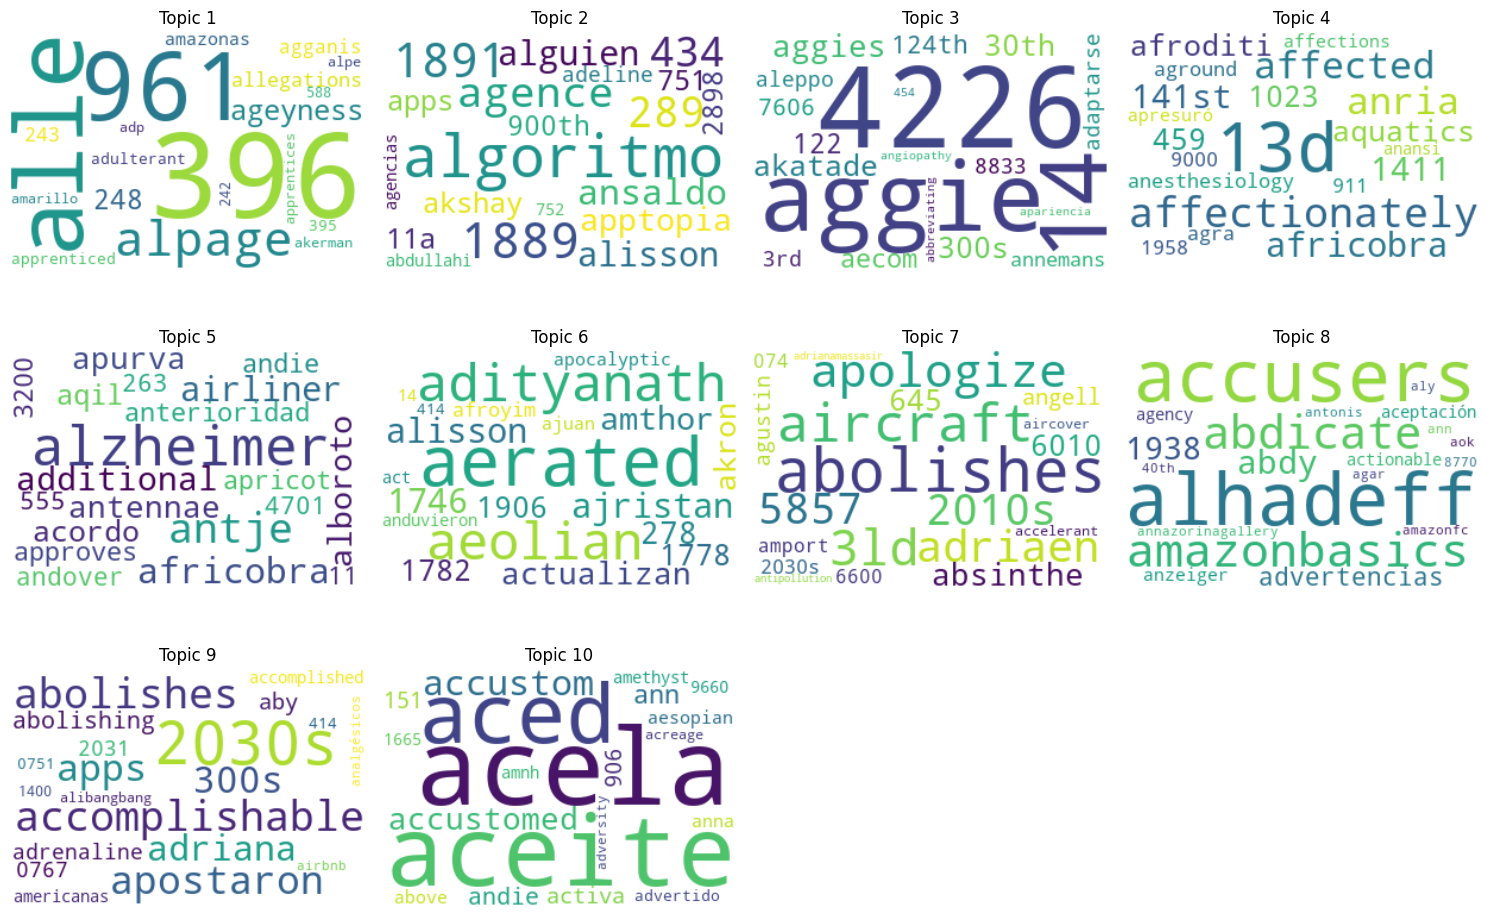

In [36]:
# Another try at topic modeling and word cloud visualization
# VSCode.Cell id="refined_topic_modeling" language="python"
# --- Refined Topic Modeling with TF-IDF, Bigrams & Hyperparameter Tuning ---

%pip install --quiet scikit-learn wordcloud matplotlib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# 1) Prepare corpus
texts = df_nyt_sample['article'].fillna('').tolist()

# 2) TF-IDF + bigrams
tfidf = TfidfVectorizer(
    max_df=0.90,        # drop very common
    min_df=15,          # drop very rare
    max_features=8000,  # limit vocab
    stop_words='english',
    ngram_range=(1,2),  # unigrams + bigrams
    token_pattern=r'\b[a-zA-Z]{3,}\b'
).fit_transform(texts)

# 3) Fit LDA with tuned priors
n_topics = 10
lda2 = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=15,
    learning_method='batch',
    doc_topic_prior=0.1,    # α smaller → sparser doc-topic
    topic_word_prior=0.01,  # β smaller → sparser topic-word
    random_state=42
).fit(tfidf)

# 4) Display top terms per topic
feature_names = TfidfVectorizer().fit(texts).get_feature_names_out()
for idx, comp in enumerate(lda2.components_):
    terms = [feature_names[i] for i in comp.argsort()[-10:][::-1]]
    print(f"Topic {idx+1}: {', '.join(terms)}")

# 5) Word-clouds
plt.figure(figsize=(15, 10))
for i, comp in enumerate(lda2.components_):
    top_idx = comp.argsort()[-20:]
    freqs   = {feature_names[j]: comp[j] for j in top_idx}
    wc = WordCloud(width=300, height=200,
                   background_color='white',
                   stopwords=STOPWORDS).generate_from_frequencies(freqs)
    plt.subplot(3, 4, i+1)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {i+1}")
plt.tight_layout()
plt.show()

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------------------------------ --------- 9.7/12.8 MB 50.5 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 37.6 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 24.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


C:\Users\MarxerB\AppData\Local\Temp\ipykernel_11220\3388899178.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


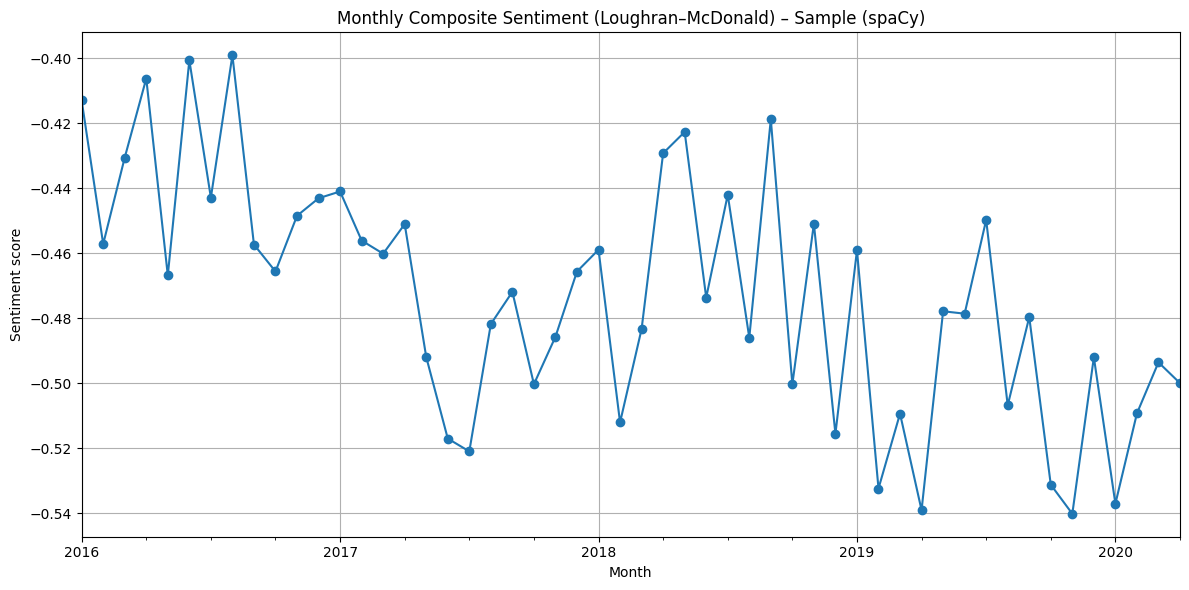

In [42]:
# VSCode.Cell id="monthly_sentiment_lmd_sample" language="python"
# --- Monthly Composite Sentiment via Loughran–McDonald (Sample) using spaCy ---

# 0) install spaCy and the small English model (run once)
!python -m spacy download en_core_web_sm

# 1) imports & spaCy setup
import pandas as pd
import spacy
from pathlib import Path
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])

# 2) load Loughran–McDonald Master Dictionary
lmd_path = "Loughran-McDonald_MasterDictionary_1993-2024.csv"
lmd = pd.read_csv(lmd_path)

# build positive/negative sets
pos_words = set(lmd.loc[lmd.Positive > 0, "Word"].str.lower())
neg_words = set(lmd.loc[lmd.Negative > 0, "Word"].str.lower())

# 3) helper to count pos/neg tokens with spaCy
def count_sentiment(text):
    doc = nlp(str(text))
    pos = 0
    neg = 0
    for tok in doc:
        w = tok.text.lower()
        if tok.is_alpha:
            if w in pos_words: pos += 1
            if w in neg_words: neg += 1
    return pd.Series({"pos": pos, "neg": neg})

# 4) apply to the sample
sent_counts = df_nyt_sample["article"].apply(count_sentiment)
df_nyt_sample = pd.concat([df_nyt_sample, sent_counts], axis=1)

# 5) compute per-article sentiment score
df_nyt_sample["sentiment"] = (
    (df_nyt_sample.pos - df_nyt_sample.neg) /
    (df_nyt_sample.pos + df_nyt_sample.neg + 1e-9)
)

# 6) aggregate monthly on the sample
df_nyt_sample["date"] = pd.to_datetime(df_nyt_sample["date"], errors="coerce")
monthly_sent = (
    df_nyt_sample
      .set_index("date")
      .resample("M")
      .apply(lambda x: (x.pos.sum() - x.neg.sum()) /
                      (x.pos.sum() + x.neg.sum() + 1e-9))
      .rename("sentiment")
)

# 7) plot
plt.figure(figsize=(12, 6))
monthly_sent.plot(marker="o", linestyle="-")
plt.title("Monthly Composite Sentiment (Loughran–McDonald) – Sample (spaCy)")
plt.xlabel("Month")
plt.ylabel("Sentiment score")
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# Save the sample to a CSV file
df_nyt_sample.to_csv('df_nyt_sample.csv', index=False)